In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import pandas_ta as ta
import pickle
from sklearn.metrics import mean_squared_error

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import sys
import os
from datetime import datetime, timedelta
sys.path.insert(1, '/home/krystian/Repos/XTB-Trader/utility')
sys.path.insert(1, '/home/krystian/Repos/XTB-Trader')
from XTBClient.api import XTBClient, PERIOD
from utility import utility 

def get_data_for_symbol(symbol):
    c = XTBClient()
    c.login(os.environ.get("XTB_user_num"), os.environ.get("XTB_pass"))
    df = c.get_candles_in_range(symbol, PERIOD.FIFTEEN_MINUTES.value, start=datetime.now() - timedelta(days=365))
    c.logout()
    
    df = df.reset_index()
    df.rename(columns={"timestamp": "date"}, inplace=True)
    
    df['date'] = df['date'].apply(pd.to_datetime)
    df.set_index('date',inplace=True)
    # df.drop([col for col in df.columns if col != "close"], axis=1, inplace=True)
    return df

def import_csv(name):
    df = pd.read_csv(name, sep=';')
    df.columns = ["date","open","high","low","close", "volume"]
    df.date = pd.to_datetime(df.date)
    df.drop(columns="volume", inplace=True)
    df.set_index('date', inplace=True, drop=True)
    return df

In [4]:
def trend_accuracy(real, preds):
    df = pd.DataFrame({"real": real, "preds": preds})
    return len(df[df.real * df.preds > 0]) / len(df)

# Data import

In [5]:
# df = yf.download(tickers = 'EURUSD=x', period='1y', interval='15m')
df = get_data_for_symbol("EURUSD")
df.index.rename("Date", inplace=True)
df.rename(columns={col: col.lower() for col in df.columns}, inplace=True)
df.index.rename(df.index.name.lower(), inplace=True)
df

,open,close,high,low,volume
date,,,,,
2023-01-01 22:00:00,1.07058,1.06932,1.07086,1.06932,187.0
2023-01-01 22:15:00,1.06932,1.06933,1.06935,1.06906,102.0
2023-01-01 22:30:00,1.06931,1.06900,1.06936,1.06857,798.0
2023-01-01 22:45:00,1.06905,1.06944,1.06981,1.06895,1980.0
2023-01-01 23:00:00,1.06922,1.06777,1.06933,1.06773,285.0
...,...,...,...,...,...
2023-07-03 17:45:00,1.09117,1.09079,1.09120,1.09079,1933.0
2023-07-03 18:00:00,1.09080,1.09116,1.09121,1.09080,2238.0
2023-07-03 18:15:00,1.09116,1.09118,1.09120,1.09105,1769.0


In [6]:
df.ta.indicators(as_list=True);

# Additional Indicators

In [7]:
df['RSI']=ta.rsi(df.close, length=15)
df['EMAF']=ta.ema(df.close, length=20)
df['EMAM']=ta.ema(df.close, length=100)
df['EMAS']=ta.ema(df.close, length=150)
df['EMAS2']=ta.ema(df.close, length=120)

df['gain'] = df['close'].diff()
df['future_gain'] = df['gain'].shift(1)
# df['future'] = df['close'].shift(1)
df = pd.concat([df, ta.stoch(df.high, df.low, df.close)], axis=1)

df.dropna(inplace=True)
df

,open,close,high,low,volume,RSI,EMAF,EMAM,EMAS,EMAS2,gain,future_gain,STOCHk_14_3_3,STOCHd_14_3_3
date,,,,,,,,,,,,,,
2023-01-03 11:15:00,1.05270,1.05261,1.05291,1.05191,12215.0,15.644104,1.057125,1.064082,1.066306,1.064679,-0.00010,-0.00035,4.157572,3.550690
2023-01-03 11:30:00,1.05260,1.05314,1.05357,1.05251,10121.0,20.275578,1.056745,1.063865,1.066132,1.064489,0.00053,-0.00010,8.574807,5.260125
2023-01-03 11:45:00,1.05314,1.05279,1.05349,1.05263,11677.0,19.517384,1.056368,1.063646,1.065955,1.064295,-0.00035,0.00053,12.849630,8.527336
2023-01-03 12:00:00,1.05280,1.05326,1.05330,1.05237,12848.0,23.626454,1.056072,1.063440,1.065787,1.064113,0.00047,-0.00035,19.409084,13.611174
2023-01-03 12:15:00,1.05324,1.05395,1.05397,1.05304,11486.0,29.303880,1.055870,1.063252,1.065630,1.063945,0.00069,0.00047,29.993749,20.750821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-03 17:45:00,1.09117,1.09079,1.09120,1.09079,1933.0,48.987178,1.091074,1.090158,1.089952,1.090049,-0.00039,-0.00023,40.555295,40.813118
2023-07-03 18:00:00,1.09080,1.09116,1.09121,1.09080,2238.0,53.284124,1.091082,1.090177,1.089968,1.090067,0.00037,-0.00039,43.553459,42.080420
2023-07-03 18:15:00,1.09116,1.09118,1.09120,1.09105,1769.0,53.510914,1.091091,1.090197,1.089984,1.090085,0.00002,0.00037,43.553459,42.554071


# Train Test split

In [8]:
# train, test = df[:int(len(df)*0.8)], df[int(len(df)*0.8):]
train = df[df.index < df.index.min() + (df.index.max() - df.index.min()) * 0.8]
test = df[df.index >= df.index.min() + (df.index.max() - df.index.min()) * 0.8]

In [9]:
len(train), len(test)

(9847, 2468)

In [10]:
target = 'future_gain'
Y_train = train[target]
X_train = train.drop(target, axis=1)

Y_test = test[target]
X_test = test.drop(target, axis=1)

# Model

In [20]:
from sklearn import linear_model

model = linear_model.LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

In [21]:
predictions = model.predict(X_test)

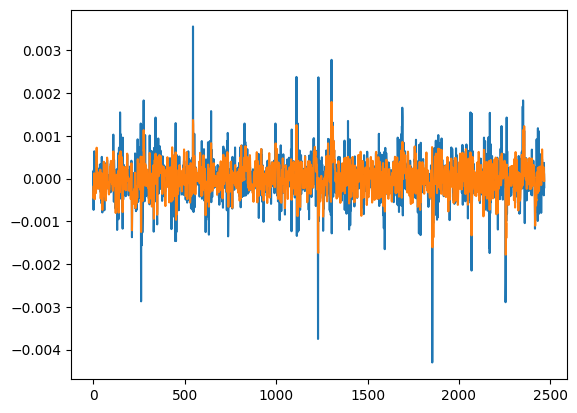

In [22]:
plt.plot(Y_test.values)
plt.plot(predictions)
plt.show()

In [23]:
rms = mean_squared_error(Y_test.values, predictions, squared=False)
rms

0.00033850836230697024

In [24]:
trend_accuracy(Y_test.values, predictions)

0.7224473257698542

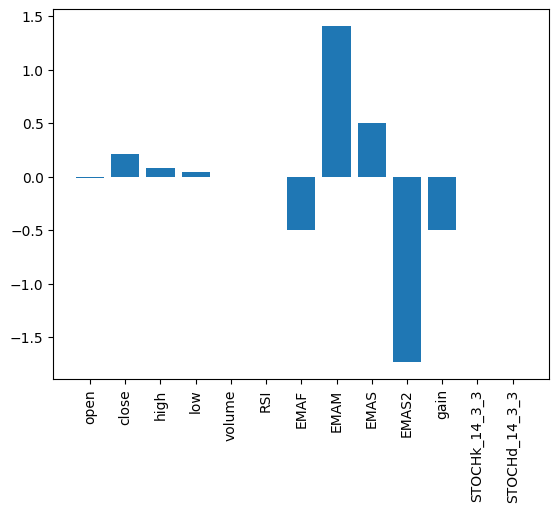

In [25]:
importance = model.coef_

plt.bar(model.feature_names_in_, importance )
plt.xticks(rotation='vertical');

# Saving the model

In [26]:
filename = os.path.join("../", "../", "models", "linear_regression.pkl")

In [27]:
pickle.dump(model, open(filename, 'wb'))

In [28]:
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
loaded_model.predict